In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests
import math


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('may_june_july.csv', delimiter="|")

In [3]:
# Combine all text 
df['tags'] = df['descr'] + " " + df["title"] + " " + df["cat"]+ " " + df["primary_kw"]+ " " + df["tags"] 
# Drop unneeded columns
df.drop('id', axis=1, inplace=True)
df.drop('pull_cc', axis=1, inplace=True)
df.drop('cc', axis=1, inplace=True)
df.drop('metav', axis=1, inplace=True)
df.drop('descr', axis=1, inplace=True)
df.drop('title', axis=1, inplace=True)
df.drop('primary_kw', axis=1, inplace=True)
df.drop('cat', axis=1, inplace=True)

df.head()

,freq,impressions,tags
0,2,29316,Giant man with tiny dog alert! The Mountain Fr...
1,2,17180,FYI: Ice cream sandwiches &gt; all other sandw...
2,2,3474,"""My mama always said you can tell a lot about ..."
3,2,9027,Let's see if you're a true cheese whiz. Can Yo...
4,2,7247,The EPA just released first-time guidelines on...


In [4]:
# NORMALIZE TO LOG DISTRIBUTION
# Compute Log (freq*impressions/1000)
# Add log column
df['Log'] = df['freq']*df['impressions']

for i, row in df.iterrows():
    cv = math.log(df.iloc[i,3],2)
    df.set_value(i,'Log',cv)

# Drop unneeded column
df.drop('freq', axis=1, inplace=True)
df.drop('impressions', axis=1, inplace=True)
df.head()

,tags,Log
0,Giant man with tiny dog alert! The Mountain Fr...,15
1,FYI: Ice cream sandwiches &gt; all other sandw...,15
2,"""My mama always said you can tell a lot about ...",12
3,Let's see if you're a true cheese whiz. Can Yo...,14
4,The EPA just released first-time guidelines on...,13


In [5]:
data_mean = df["Log"].mean()
data_mean

19.444149122193465

In [6]:
data_std = df["Log"].std()
data_std

3.2282119418494077

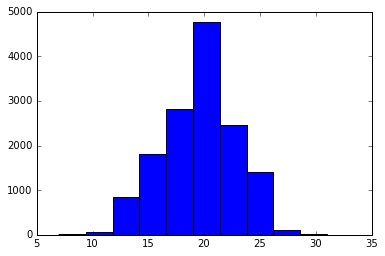

In [7]:
plt.hist(df["Log"])
plt.show()

In [8]:
# Virality defined as -1 sigma from mean
df['viral'] = np.where(df['Log']<data_mean-data_std, 'notviral', 'viral')
df['viral_num'] = df.viral.map({'notviral':0, 'viral':1})
df.drop('Log', axis=1, inplace=True)
df.head()

,tags,viral,viral_num
0,Giant man with tiny dog alert! The Mountain Fr...,notviral,0
1,FYI: Ice cream sandwiches &gt; all other sandw...,notviral,0
2,"""My mama always said you can tell a lot about ...",notviral,0
3,Let's see if you're a true cheese whiz. Can Yo...,notviral,0
4,The EPA just released first-time guidelines on...,notviral,0


In [9]:
df['tags'].fillna('a', inplace=True)

In [10]:
df.tail()

,tags,viral,viral_num
14292,A former Stanford swimmer who sexually assault...,viral,1
14293,A former Stanford swimmer who sexually assault...,viral,1
14294,A former Stanford swimmer who sexually assault...,viral,1
14295,A definitive ranking of our dirtiest words. Th...,viral,1
14296,"Don't worry, you won't need to know Chandler B...",viral,1


In [11]:
df.shape

(14297, 3)

In [12]:
df.viral.value_counts()

viral       11564
notviral     2733
Name: viral, dtype: int64

In [13]:
X = df.tags
y = df.viral_num
print(X.shape)
print(y.shape)

(14297,)
(14297,)


In [14]:
X.head()

0    Giant man with tiny dog alert! The Mountain Fr...
1    FYI: Ice cream sandwiches &gt; all other sandw...
2    "My mama always said you can tell a lot about ...
3    Let's see if you're a true cheese whiz. Can Yo...
4    The EPA just released first-time guidelines on...
Name: tags, dtype: object

In [15]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: viral_num, dtype: int64

In [16]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10722,)
(3575,)
(10722,)
(3575,)


In [17]:
# instantiate the vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [18]:
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
# learn training data vocabulary, then use it to create a document-term matrix
# FOLLOWING CAN BE DONE IN SINGLE STEP:  X_train_dtm = vect.fit_transform(X_train)
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [20]:
X_train_dtm

<10722x15480 sparse matrix of type '<class 'numpy.int64'>'
	with 266669 stored elements in Compressed Sparse Row format>

In [21]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<3575x15480 sparse matrix of type '<class 'numpy.int64'>'
	with 87915 stored elements in Compressed Sparse Row format>

In [22]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [23]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 5.83 ms, sys: 1.48 ms, total: 7.3 ms
Wall time: 6.45 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [25]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.78965034965034964

In [26]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 243,  466],
       [ 286, 2580]])

In [27]:
# print message text for the false positives (non-viral incorrectly classified as viral)
X_test[y_test < y_pred_class]

2356     So much fierce, so little time. Here's What A ...
4046     Robert Czegely has been accused of "gross misc...
3116     Put your JT fandom to the test. Are These Nsyn...
1094     Hold the door. 53 Thoughts I Had Watching Seas...
1312     Identify them all! Can You Guess The Pok mon B...
3807     Three of the former Libyan dictator s top offi...
2410     Tiny home, big clean. 28 Clever Ways To Deep C...
2813     Today's characters: the Malfoys. Here Are The ...
4781     <b>These big rocks in the desert will blow you...
3312     For when you want a little bit of ~everything....
10363    Yes, I want my house to smell like fairy bread...
3895     "Next week will see the debut of Hodor's cousi...
4290     Some Bernie-or-Busters protested Clinton's spe...
1401     Underrated is an UNDERstatement. It's Time To ...
32       Michelle Carter was charged with involuntary m...
11347    Put all those geography classes to the test. C...
1578                                                    

In [28]:
# print message text for the false negatives (Viral incorrectly classified as non-viral)
X_test[y_test > y_pred_class]

7120     "You spent some time away..." Brace Yourselves...
11141    Mmmmmmmmmmmmmmmm. 16 Extremely Satisfying Pict...
12571    It wasn't. 17 Things That Will Make Every Indi...
5558     "You're worthy of the last French fry in the b...
10655    Worse still, literally no one is surprised. De...
14152    In 2016, it takes staggering ignorance to thin...
13227    "I am no longer okay with just being a sidekic...
11674    The school has thousands of students, no full-...
11436    "I have always said, I will work after marriag...
9034     TL;DR Poo is done with your shit. Kareena Kapo...
13466    It seems that the key is to live anywhere othe...
5811     A hot new type of food stack. People On Instag...
1175     Give those old duds new life. 18 No-Sew Ways T...
3153     The pound may be weak, but the memes are stron...
6004     She was a better Trump than Trump. Meryl Stree...
5640     Vote Leave, take back the status quo? Four Bre...
11646    Pappis for puppies. 9 Pictures Of Doggies At I.

In [30]:
# example false negative
X_test[6454]

'<b>Temper your jealousy, teachers.</b> One can always dream. 30 Epic Examples Of Inspirational Classroom Decor DIY classrooms awesome design classroom decor classroom design cool classrooms design teacher decorations teachers'

In [31]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([ 0.35800925,  0.99945296,  0.99999878, ...,  0.99999947,
        0.9999996 ,  0.98753744])

In [32]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.73793648012740198

In [33]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [34]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 384 ms, sys: 5.54 ms, total: 389 ms
Wall time: 392 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [36]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([ 0.77864268,  0.95959005,  0.98801846, ...,  0.98512148,
        0.97422148,  0.74503525])

In [37]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.80083916083916085

In [38]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.72567856991703716

In [39]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

15480

In [40]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

['00', '000', '007', '00s', '03', '06', '07', '10', '100', '100000', '100m', '101', '11', '110', '11th', '12', '125', '129', '13', '14', '140', '143', '15', '150', '1500', '151', '16', '160', '16_new_food', '16th', '17', '172', '177', '1789', '17th', '18', '182', '18311', '18th', '19', '1938922913', '1955', '1960s', '1964', '1966', '1969', '1970s', '1972', '1980', '1980s']


In [41]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

['zachary', 'zack', 'zackary', 'zafar', 'zafn', 'zaful', 'zag', 'zakia', 'zambia', 'zanada', 'zara', 'zaveri', 'zayn', 'zbych', 'zealand', 'zebra', 'zelda', 'zemeckis', 'zen', 'zendaya', 'zero', 'zesty', 'zeus', 'zhang', 'zhao', 'zig', 'zika', 'zinger', 'zip', 'zit', 'ziva', 'zo', 'zodiac', 'zodiacquiz', 'zoe', 'zoey', 'zombies', 'zone', 'zoo', 'zoodles', 'zooey', 'zookeeper', 'zoom', 'zootopia', 'zoren', 'zucchini', 'zuchinni', 'zuckerberg', 'zwan', 'zz']


In [42]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[  0.,   7.,   4., ...,   1.,   0.,   1.],
       [  4.,  39.,   4., ...,   2.,   3.,   1.]])

In [43]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 15480)

In [44]:
# number of times each token appears across all Non-viral Buzzes
non_viral_token_count = nb.feature_count_[0, :]
non_viral_token_count

array([ 0.,  7.,  4., ...,  1.,  0.,  1.])

In [45]:
# number of times each token appears across all Viral Buzzes
viral_token_count = nb.feature_count_[1, :]
viral_token_count

array([  4.,  39.,   4., ...,   2.,   3.,   1.])

In [46]:
# create a DataFrame of tokens with their separate non-viral and viral counts
tokens = pd.DataFrame({'token':X_train_tokens, 'non_viral':non_viral_token_count, 'viral':viral_token_count}).set_index('token')
tokens.head()

,non_viral,viral
token,,
00,0.0,4.0
000,7.0,39.0
007,4.0,4.0
00s,27.0,207.0
03,0.0,3.0


In [47]:
# examine 5 random DataFrame rows
tokens.sample(20, random_state=6)

,non_viral,viral
token,,
realest,1.0,2.0
creeps,0.0,2.0
meredith,3.0,6.0
nz,0.0,2.0
nadu,2.0,3.0
unqualified,0.0,1.0
deep,4.0,59.0
belgium,2.0,0.0
dax,4.0,9.0


In [48]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([ 2024.,  8698.])

In [49]:
# add 1 to non-viral and viral counts to avoid dividing by 0
tokens['non_viral'] = tokens.non_viral + 1
tokens['viral'] = tokens.viral + 1
tokens.sample(5, random_state=6)

,non_viral,viral
token,,
realest,2.0,3.0
creeps,1.0,3.0
meredith,4.0,7.0
nz,1.0,3.0
nadu,3.0,4.0


In [50]:
# convert the non-viral and viral counts into frequencies
tokens['non_viral'] = tokens.non_viral / nb.class_count_[0]
tokens['viral'] = tokens.viral / nb.class_count_[1]
tokens.sample(5, random_state=6)

,non_viral,viral
token,,
realest,0.000988,0.000345
creeps,0.000494,0.000345
meredith,0.001976,0.000805
nz,0.000494,0.000345
nadu,0.001482,0.000460


In [51]:
# calculate the ratio of viral-to-non-viral for each token
tokens['viral_ratio'] = tokens.viral / tokens.non_viral
tokens.sample(5, random_state=6)

,non_viral,viral,viral_ratio
token,,,
realest,0.000988,0.000345,0.349046
creeps,0.000494,0.000345,0.698092
meredith,0.001976,0.000805,0.407220
nz,0.000494,0.000345,0.698092
nadu,0.001482,0.000460,0.310263


In [52]:
# examine the DataFrame sorted by viral_ratio
# note: use sort() instead of sort_values() for pandas 0.16.2 and earlier
tokens.sort_values('viral_ratio', ascending=False)

,non_viral,viral,viral_ratio
token,,,
stanford,0.000494,0.014141,28.621752
petty,0.000494,0.007358,14.892619
gym,0.000494,0.007013,14.194527
jonas,0.000494,0.005633,11.402161
san,0.000494,0.004944,10.005978
yeah,0.000494,0.004599,9.307887
victoria,0.000494,0.004254,8.609795
hairy,0.000494,0.004254,8.609795
beckham,0.000494,0.004139,8.377098


In [54]:
# look up the viral_ratio for a given token
tokens.loc['lol', 'viral_ratio']

1.3186173066605349